In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch import optim
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
from collections import Counter
import csv

import nltk
from nltk.tokenize import word_tokenize
from nltk import PorterStemmer
from nltk import WordNetLemmatizer
from torch.utils.data import TensorDataset, DataLoader
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

импорт нужных библиотек и считывание датасета из файла

In [17]:
from google.colab import files
data_to_load = files.upload()

Saving reviews.csv to reviews (1).csv


In [20]:
import io
df = pd.read_csv(io.BytesIO(data_to_load['reviews (1).csv']))
df

,review,star
0,"Банк столько раз меня обманывал, что жду не до...",1
1,К клиентам никакого уважения- не зависит от ка...,1
2,Добрый день!,1
3,"и маркетплейсах, а также в продуктовых магазин...",1
4,27 октября в отделении банка было создано обра...,1
...,...,...
2963,"Здравствуйте,хочется поблагодарить работника о...",5
2964,NaN,5
2965,Когда-то давным-давно я пользовалась картой Ал...,5
2966,Хочется похвалить сотрудников онлайн-чата и со...,5


In [38]:
change_labels = lambda x: 1 if x==4 or x==5 else 0
df['star'] = df['star'].apply(change_labels)

удаляем пустые строки из датасета

In [39]:
df.dropna(inplace =True)
df

,review,star
0,банк столько раз меня обманывал что жду не дож...,0
1,не от к клиентам никакого уважения зависит кат...,0
2,добрый день,0
3,и маркетплейсах а также в продуктовых магазина...,0
4,и в обращение предложений по кредиту кредитным...,0
...,...,...
2962,и за бонус в сентябре я оформил карту альфа ба...,1
2963,карты все здравствуйте хочется поблагодарить р...,1
2965,не и на все я но карту это мне тимур так что а...,1
2966,в и банка документов сотрудников чата обратилс...,1


обработка текста отзыва

In [40]:
remove_non_alphabets = lambda x: re.sub(r'[^\w\s]', ' ', x, flags=re.UNICODE)

tokenize = lambda x: word_tokenize(x)

ps = PorterStemmer()
stem = lambda w: [ps.stem(x) for x in w]

lemmatizer = WordNetLemmatizer()
leammtizer = lambda x: [lemmatizer.lemmatize(word) for word in x]

counter = lambda x: Counter(x)
sort_words = lambda x: list((dict(sorted(x.items(), key=lambda item: item[1], reverse=True)[:500])).keys())

In [41]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [42]:
print('Start processing')
df['review'] = df['review'].apply(remove_non_alphabets)
print('removed non alphabets')
df['review'] = df['review'].apply(tokenize)
print('tokenized')
df['review'] = df['review'].apply(stem)
print('stemmed')
df['review'] = df['review'].apply(leammtizer)
print('lemmatized')
df['review'] = df['review'].apply(counter)
print('counted')
df['review'] = df['review'].apply(sort_words)
print('sorted')
df['review'] = df['review'].apply(lambda x: ' '.join(x))
print('End of processing')
df

Start processing
removed non alphabets
tokenized
stemmed
lemmatized
counted
sorted
End of processing


,review,star
0,банк столько раз меня обманывал что жду не дож...,0
1,не от к клиентам никакого уважения зависит кат...,0
2,добрый день,0
3,и маркетплейсах а также в продуктовых магазина...,0
4,и в обращение предложений по кредиту кредитным...,0
...,...,...
2962,и за бонус в сентябре я оформил карту альфа ба...,1
2963,карты все здравствуйте хочется поблагодарить р...,1
2965,не и на все я но карту это мне тимур так что а...,1
2966,в и банка документов сотрудников чата обратилс...,1


векторизация:

In [43]:
russian_stopwords = stopwords.words('russian')

In [44]:
max_words = 500
cv = CountVectorizer(max_features=max_words, stop_words=russian_stopwords)
sparse_matrix = cv.fit_transform(df['review']).toarray()

In [45]:
sparse_matrix.shape

(2912, 500)

создание модели нейросети:

In [46]:
class Model(nn.Module):
   def __init__(self):
       super(Model, self).__init__()
       self.fc1 = nn.Linear(500, 50)
       self.fc2 = nn.Linear(50, 20)
       self.fc3 = nn.Linear(20, 10)
       self.fc4 = nn.Linear(10, 2)

   def forward(self, x):
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = F.relu(self.fc3(x))
      x = self.fc4(x)
      return x

In [47]:
x_train, x_tmp, y_train, y_tmp = train_test_split(sparse_matrix, np.array(df['star']), test_size=0.2, random_state=42)

разделение временной выборки на тестовую и валидационную выборки


In [48]:
x_test, x_valid, y_test, y_valid = train_test_split(x_tmp, y_tmp, test_size=0.5, random_state=42)

In [49]:
x_train = Variable(torch.from_numpy(x_train)).float()
y_train = Variable(torch.from_numpy(y_train)).long()
x_test = Variable(torch.from_numpy(x_test)).float()
y_test = Variable(torch.from_numpy(y_test)).long()
x_valid = Variable(torch.from_numpy(x_valid)).float()
y_valid = Variable(torch.from_numpy(y_valid)).long()

In [50]:
train_dataset = TensorDataset(x_train, y_train)
valid_dataset = TensorDataset(x_valid, y_valid)
test_dataset = TensorDataset(x_test, y_test)

In [51]:
learning_rates = [0.0001, 0.001, 0.01]
batch_sizes = [32, 64, 128]
epochs = 40
loss_values = []
models = []

создание модели:

In [52]:
model = Model()

Epoch 1/40, Training Loss: 0.6736, Training Accuracy: 0.5887, Validation Loss: 0.6635, Validation Accuracy: 0.6027
Epoch 2/40, Training Loss: 0.6533, Training Accuracy: 0.5908, Validation Loss: 0.6375, Validation Accuracy: 0.6130
Epoch 3/40, Training Loss: 0.6061, Training Accuracy: 0.7351, Validation Loss: 0.5633, Validation Accuracy: 0.8664
Epoch 4/40, Training Loss: 0.5108, Training Accuracy: 0.9150, Validation Loss: 0.4358, Validation Accuracy: 0.9486
Epoch 5/40, Training Loss: 0.3842, Training Accuracy: 0.9652, Validation Loss: 0.3179, Validation Accuracy: 0.9829
Epoch 6/40, Training Loss: 0.2714, Training Accuracy: 0.9725, Validation Loss: 0.2200, Validation Accuracy: 0.9863
Epoch 7/40, Training Loss: 0.1942, Training Accuracy: 0.9802, Validation Loss: 0.1571, Validation Accuracy: 0.9863
Epoch 8/40, Training Loss: 0.1443, Training Accuracy: 0.9802, Validation Loss: 0.1282, Validation Accuracy: 0.9863
Epoch 9/40, Training Loss: 0.1120, Training Accuracy: 0.9802, Validation Loss: 0

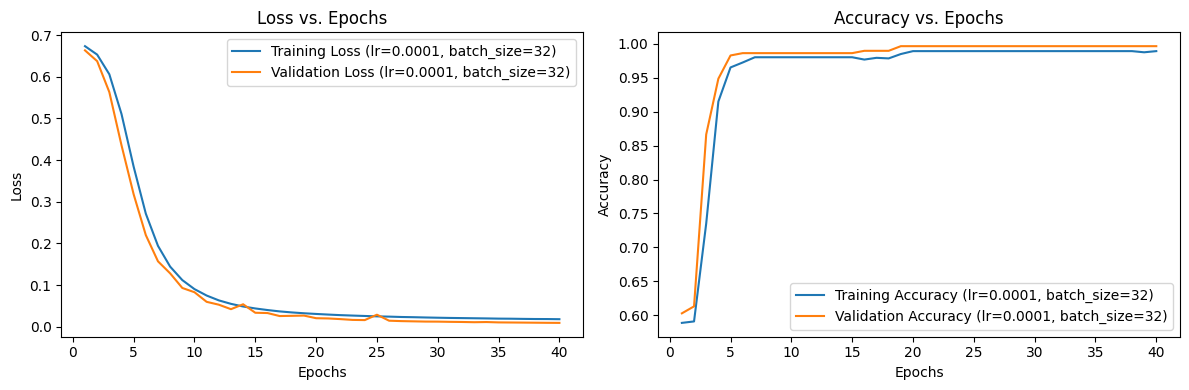

Epoch 1/40, Training Loss: 0.0182, Training Accuracy: 0.9893, Validation Loss: 0.0091, Validation Accuracy: 0.9966
Epoch 2/40, Training Loss: 0.0173, Training Accuracy: 0.9893, Validation Loss: 0.0112, Validation Accuracy: 0.9966
Epoch 3/40, Training Loss: 0.0189, Training Accuracy: 0.9893, Validation Loss: 0.0088, Validation Accuracy: 0.9966
Epoch 4/40, Training Loss: 0.0172, Training Accuracy: 0.9893, Validation Loss: 0.0085, Validation Accuracy: 0.9966
Epoch 5/40, Training Loss: 0.0171, Training Accuracy: 0.9893, Validation Loss: 0.0084, Validation Accuracy: 0.9966
Epoch 6/40, Training Loss: 0.0164, Training Accuracy: 0.9893, Validation Loss: 0.0084, Validation Accuracy: 0.9966
Epoch 7/40, Training Loss: 0.0173, Training Accuracy: 0.9893, Validation Loss: 0.0083, Validation Accuracy: 0.9966
Epoch 8/40, Training Loss: 0.0172, Training Accuracy: 0.9893, Validation Loss: 0.0098, Validation Accuracy: 0.9966
Epoch 9/40, Training Loss: 0.0169, Training Accuracy: 0.9880, Validation Loss: 0

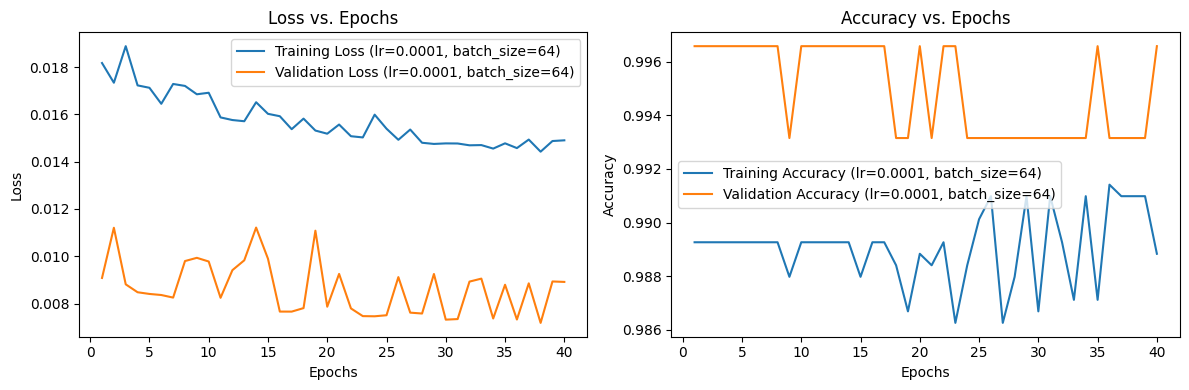

Epoch 1/40, Training Loss: 0.0153, Training Accuracy: 0.9893, Validation Loss: 0.0058, Validation Accuracy: 0.9966
Epoch 2/40, Training Loss: 0.0140, Training Accuracy: 0.9893, Validation Loss: 0.0105, Validation Accuracy: 0.9932
Epoch 3/40, Training Loss: 0.0139, Training Accuracy: 0.9910, Validation Loss: 0.0108, Validation Accuracy: 0.9932
Epoch 4/40, Training Loss: 0.0163, Training Accuracy: 0.9910, Validation Loss: 0.0060, Validation Accuracy: 0.9932
Epoch 5/40, Training Loss: 0.0139, Training Accuracy: 0.9910, Validation Loss: 0.0060, Validation Accuracy: 0.9932
Epoch 6/40, Training Loss: 0.0139, Training Accuracy: 0.9910, Validation Loss: 0.0060, Validation Accuracy: 0.9932
Epoch 7/40, Training Loss: 0.0139, Training Accuracy: 0.9910, Validation Loss: 0.0064, Validation Accuracy: 0.9932
Epoch 8/40, Training Loss: 0.0139, Training Accuracy: 0.9910, Validation Loss: 0.0107, Validation Accuracy: 0.9932
Epoch 9/40, Training Loss: 0.0139, Training Accuracy: 0.9910, Validation Loss: 0

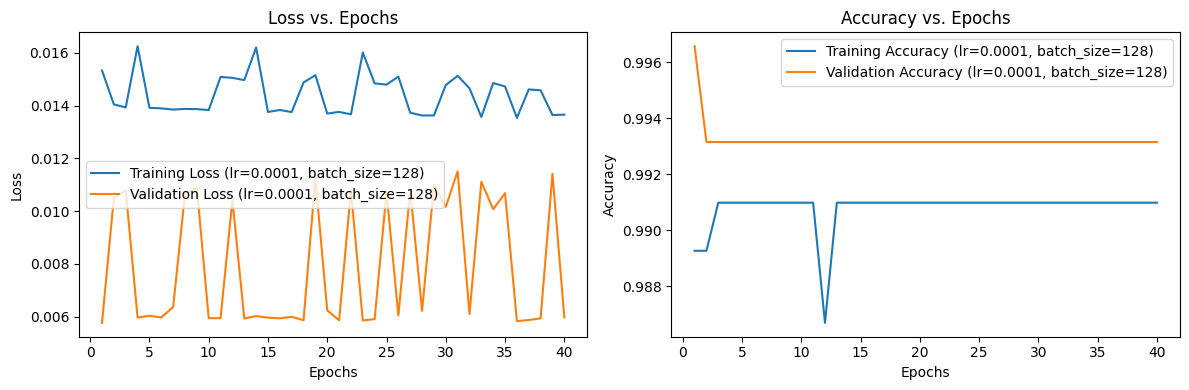

Epoch 1/40, Training Loss: 0.0157, Training Accuracy: 0.9888, Validation Loss: 0.0069, Validation Accuracy: 0.9932
Epoch 2/40, Training Loss: 0.0148, Training Accuracy: 0.9888, Validation Loss: 0.0069, Validation Accuracy: 0.9932
Epoch 3/40, Training Loss: 0.0145, Training Accuracy: 0.9875, Validation Loss: 0.0086, Validation Accuracy: 0.9932
Epoch 4/40, Training Loss: 0.0150, Training Accuracy: 0.9910, Validation Loss: 0.0065, Validation Accuracy: 0.9966
Epoch 5/40, Training Loss: 0.0150, Training Accuracy: 0.9893, Validation Loss: 0.0067, Validation Accuracy: 0.9932
Epoch 6/40, Training Loss: 0.0147, Training Accuracy: 0.9906, Validation Loss: 0.0067, Validation Accuracy: 0.9932
Epoch 7/40, Training Loss: 0.0148, Training Accuracy: 0.9897, Validation Loss: 0.0071, Validation Accuracy: 0.9932
Epoch 8/40, Training Loss: 0.0153, Training Accuracy: 0.9914, Validation Loss: 0.0061, Validation Accuracy: 0.9966
Epoch 9/40, Training Loss: 0.0144, Training Accuracy: 0.9910, Validation Loss: 0

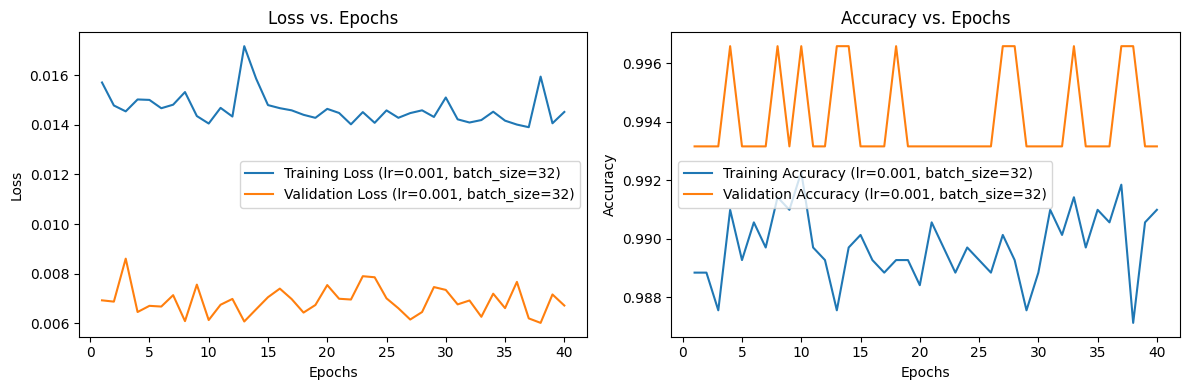

Epoch 1/40, Training Loss: 0.0144, Training Accuracy: 0.9906, Validation Loss: 0.0070, Validation Accuracy: 0.9932
Epoch 2/40, Training Loss: 0.0141, Training Accuracy: 0.9880, Validation Loss: 0.0088, Validation Accuracy: 0.9932
Epoch 3/40, Training Loss: 0.0139, Training Accuracy: 0.9888, Validation Loss: 0.0069, Validation Accuracy: 0.9932
Epoch 4/40, Training Loss: 0.0141, Training Accuracy: 0.9914, Validation Loss: 0.0076, Validation Accuracy: 0.9966
Epoch 5/40, Training Loss: 0.0140, Training Accuracy: 0.9906, Validation Loss: 0.0071, Validation Accuracy: 0.9932
Epoch 6/40, Training Loss: 0.0140, Training Accuracy: 0.9880, Validation Loss: 0.0076, Validation Accuracy: 0.9932
Epoch 7/40, Training Loss: 0.0143, Training Accuracy: 0.9910, Validation Loss: 0.0067, Validation Accuracy: 0.9932
Epoch 8/40, Training Loss: 0.0140, Training Accuracy: 0.9893, Validation Loss: 0.0093, Validation Accuracy: 0.9932
Epoch 9/40, Training Loss: 0.0138, Training Accuracy: 0.9880, Validation Loss: 0

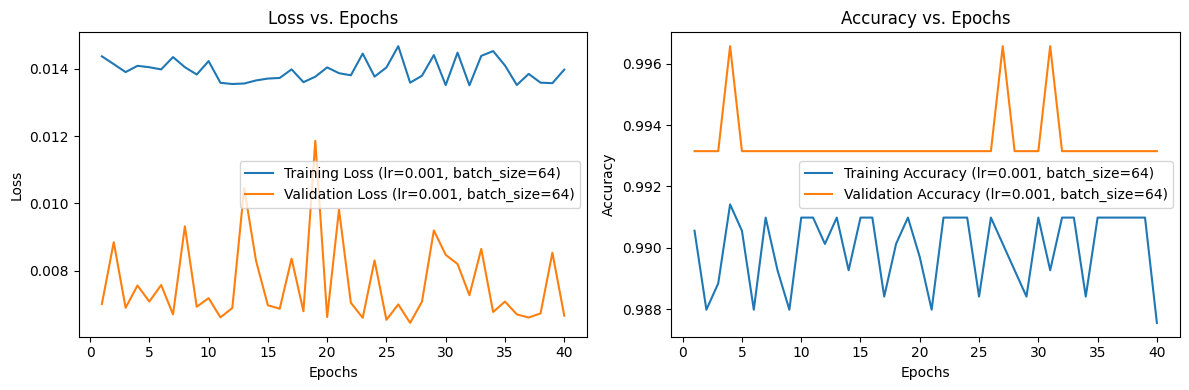

Epoch 1/40, Training Loss: 0.0134, Training Accuracy: 0.9893, Validation Loss: 0.0104, Validation Accuracy: 0.9932
Epoch 2/40, Training Loss: 0.0145, Training Accuracy: 0.9910, Validation Loss: 0.0058, Validation Accuracy: 0.9932
Epoch 3/40, Training Loss: 0.0131, Training Accuracy: 0.9910, Validation Loss: 0.0103, Validation Accuracy: 0.9932
Epoch 4/40, Training Loss: 0.0143, Training Accuracy: 0.9897, Validation Loss: 0.0057, Validation Accuracy: 0.9932
Epoch 5/40, Training Loss: 0.0158, Training Accuracy: 0.9910, Validation Loss: 0.0061, Validation Accuracy: 0.9932
Epoch 6/40, Training Loss: 0.0170, Training Accuracy: 0.9910, Validation Loss: 0.0056, Validation Accuracy: 0.9932
Epoch 7/40, Training Loss: 0.0131, Training Accuracy: 0.9910, Validation Loss: 0.0054, Validation Accuracy: 0.9932
Epoch 8/40, Training Loss: 0.0132, Training Accuracy: 0.9884, Validation Loss: 0.0057, Validation Accuracy: 0.9932
Epoch 9/40, Training Loss: 0.0132, Training Accuracy: 0.9910, Validation Loss: 0

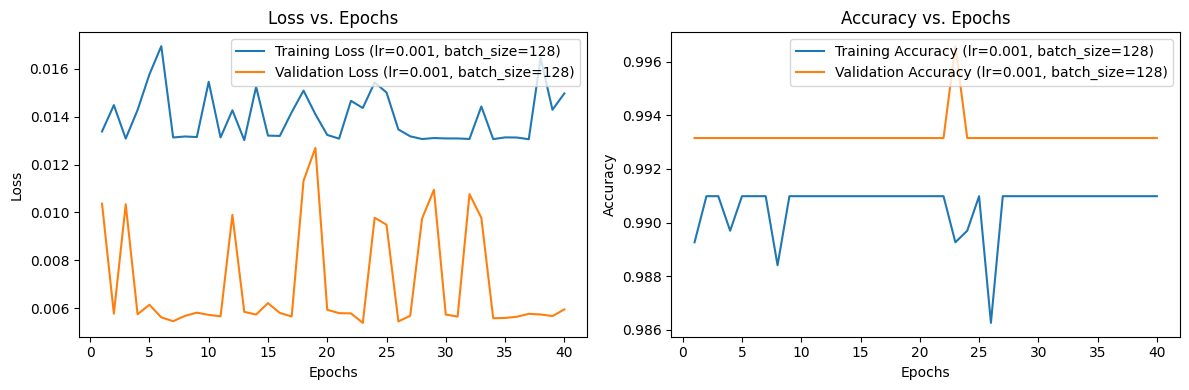

Epoch 1/40, Training Loss: 0.0566, Training Accuracy: 0.9880, Validation Loss: 0.0180, Validation Accuracy: 0.9932
Epoch 2/40, Training Loss: 0.0140, Training Accuracy: 0.9910, Validation Loss: 0.0070, Validation Accuracy: 0.9932
Epoch 3/40, Training Loss: 0.0139, Training Accuracy: 0.9910, Validation Loss: 0.0069, Validation Accuracy: 0.9932
Epoch 4/40, Training Loss: 0.0138, Training Accuracy: 0.9910, Validation Loss: 0.0068, Validation Accuracy: 0.9932
Epoch 5/40, Training Loss: 0.0137, Training Accuracy: 0.9910, Validation Loss: 0.0068, Validation Accuracy: 0.9932
Epoch 6/40, Training Loss: 0.0138, Training Accuracy: 0.9910, Validation Loss: 0.0068, Validation Accuracy: 0.9932
Epoch 7/40, Training Loss: 0.0138, Training Accuracy: 0.9910, Validation Loss: 0.0069, Validation Accuracy: 0.9932
Epoch 8/40, Training Loss: 0.0137, Training Accuracy: 0.9910, Validation Loss: 0.0068, Validation Accuracy: 0.9932
Epoch 9/40, Training Loss: 0.0138, Training Accuracy: 0.9910, Validation Loss: 0

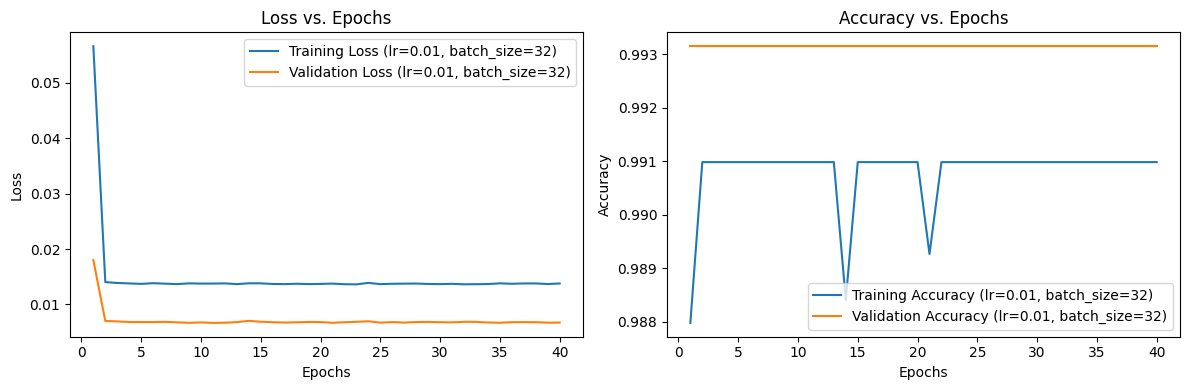

Epoch 1/40, Training Loss: 0.0147, Training Accuracy: 0.9906, Validation Loss: 0.0067, Validation Accuracy: 0.9932
Epoch 2/40, Training Loss: 0.0135, Training Accuracy: 0.9910, Validation Loss: 0.0067, Validation Accuracy: 0.9932
Epoch 3/40, Training Loss: 0.0136, Training Accuracy: 0.9910, Validation Loss: 0.0085, Validation Accuracy: 0.9932
Epoch 4/40, Training Loss: 0.0135, Training Accuracy: 0.9910, Validation Loss: 0.0067, Validation Accuracy: 0.9932
Epoch 5/40, Training Loss: 0.0135, Training Accuracy: 0.9910, Validation Loss: 0.0087, Validation Accuracy: 0.9932
Epoch 6/40, Training Loss: 0.0134, Training Accuracy: 0.9910, Validation Loss: 0.0087, Validation Accuracy: 0.9932
Epoch 7/40, Training Loss: 0.0135, Training Accuracy: 0.9910, Validation Loss: 0.0068, Validation Accuracy: 0.9932
Epoch 8/40, Training Loss: 0.0143, Training Accuracy: 0.9910, Validation Loss: 0.0067, Validation Accuracy: 0.9932
Epoch 9/40, Training Loss: 0.0134, Training Accuracy: 0.9910, Validation Loss: 0

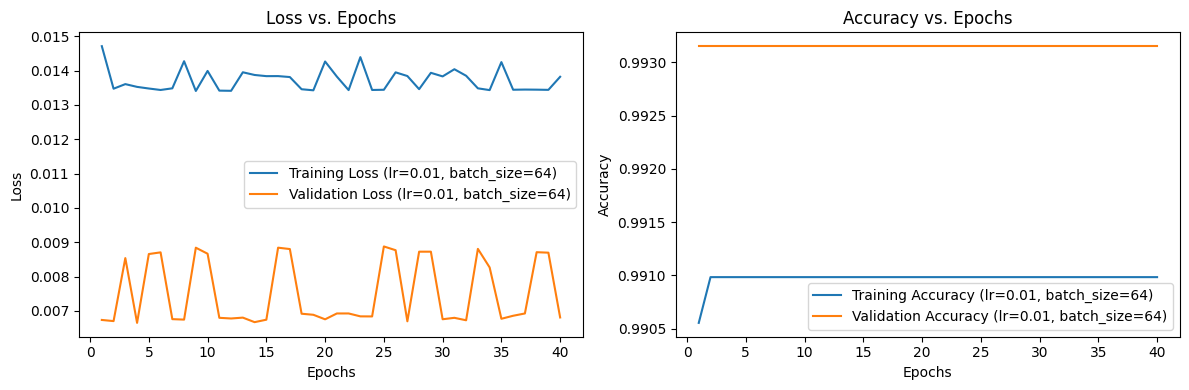

Epoch 1/40, Training Loss: 0.0145, Training Accuracy: 0.9910, Validation Loss: 0.0111, Validation Accuracy: 0.9932
Epoch 2/40, Training Loss: 0.0131, Training Accuracy: 0.9910, Validation Loss: 0.0098, Validation Accuracy: 0.9932
Epoch 3/40, Training Loss: 0.0131, Training Accuracy: 0.9910, Validation Loss: 0.0056, Validation Accuracy: 0.9932
Epoch 4/40, Training Loss: 0.0141, Training Accuracy: 0.9910, Validation Loss: 0.0057, Validation Accuracy: 0.9932
Epoch 5/40, Training Loss: 0.0131, Training Accuracy: 0.9910, Validation Loss: 0.0057, Validation Accuracy: 0.9932
Epoch 6/40, Training Loss: 0.0154, Training Accuracy: 0.9910, Validation Loss: 0.0057, Validation Accuracy: 0.9932
Epoch 7/40, Training Loss: 0.0144, Training Accuracy: 0.9910, Validation Loss: 0.0057, Validation Accuracy: 0.9932
Epoch 8/40, Training Loss: 0.0130, Training Accuracy: 0.9910, Validation Loss: 0.0056, Validation Accuracy: 0.9932
Epoch 9/40, Training Loss: 0.0131, Training Accuracy: 0.9910, Validation Loss: 0

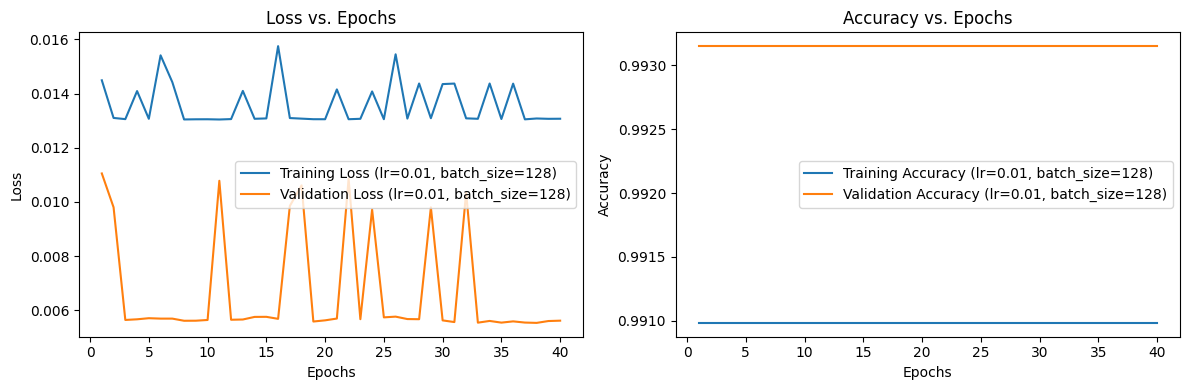

Test Accuracy: 0.9828


In [53]:
for lr in learning_rates:
    for batch_size in batch_sizes:
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        # Training loop
        train_losses = []
        valid_losses = []
        train_accuracy = []
        valid_accuracy = []

        for epoch in range(epochs):
            model.train()

            running_loss = 0.0
            correct_train = 0
            total_train = 0

            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()

            train_losses.append(running_loss / len(train_loader))
            train_accuracy.append(correct_train / total_train)

            # Validation
            model.eval()

            running_loss = 0.0
            correct_valid = 0
            total_valid = 0

            with torch.no_grad():
                for inputs, labels in valid_loader:
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    running_loss += loss.item()

                    _, predicted = torch.max(outputs, 1)
                    total_valid += labels.size(0)
                    correct_valid += (predicted == labels).sum().item()

                valid_losses.append(running_loss / len(valid_loader))
                valid_accuracy.append(correct_valid / total_valid)

                print(f'Epoch {epoch + 1}/{epochs}, '
                      f'Training Loss: {train_losses[-1]:.4f}, Training Accuracy: {train_accuracy[-1]:.4f}, '
                      f'Validation Loss: {valid_losses[-1]:.4f}, Validation Accuracy: {valid_accuracy[-1]:.4f}')
                models.append(model)

        # Visualization
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(range(1, epochs + 1), train_losses, label=f'Training Loss (lr={lr}, batch_size={batch_size})')
        plt.plot(range(1, epochs + 1), valid_losses, label=f'Validation Loss (lr={lr}, batch_size={batch_size})')
        plt.legend()
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Loss vs. Epochs')

        plt.subplot(1, 2, 2)
        plt.plot(range(1, epochs + 1), train_accuracy, label=f'Training Accuracy (lr={lr}, batch_size={batch_size})')
        plt.plot(range(1, epochs + 1), valid_accuracy, label=f'Validation Accuracy (lr={lr}, batch_size={batch_size})')
        plt.legend()
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Accuracy vs. Epochs')

        plt.tight_layout()
        plt.show()

# Evaluate model on the test set
model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = test_correct / test_total
print(f'Test Accuracy: {test_accuracy:.4f}')

повторная инициализация модели

In [55]:
batch_size = 32
lr = 0.0001
model = Model()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

            # Training loop
train_losses = []
valid_losses = []
train_accuracy = []
valid_accuracy = []

epochs = 10

for epoch in range(epochs):
    model.train()

    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracy.append(correct_train / total_train)

            # Validation
    model.eval()

    running_loss = 0.0
    correct_valid = 0
    total_valid = 0

    with torch.no_grad():
        for inputs, labels in valid_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_valid += labels.size(0)
            correct_valid += (predicted == labels).sum().item()

        valid_losses.append(running_loss / len(valid_loader))
        valid_accuracy.append(correct_valid / total_valid)

сохраняем модель

In [56]:
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, 'model.pth')

проверяем на работоспособность

In [57]:
sample_review = """
К клиентам никакого уважения- не зависит от категории обслуживания, им все равно у кого ЗАБИРАТЬ! Но реклама хорошая-
работают быстро, когда нужно отжать ₽₽₽ клиента. Видимо поэтому и большие %%% предлагают. Наглые обманщики, а не банк. Не то что компенсации от них не дождешься,
своего не вернешь. Не связывайтесь с этим ОБМАНбанком- намучаетесь!
"""

In [59]:
sample_review = remove_non_alphabets(sample_review)
sample_review = tokenize(sample_review)
sample_review = stem(sample_review)
sample_review = leammtizer(sample_review)
sample_review = counter(sample_review)
sample_review = sort_words(sample_review)
sample_review = ' '.join(sample_review)
sample_review

'не от к клиентам никакого уважения зависит категории обслуживания им все равно у кого забирать но реклама хорошая работают быстро когда нужно отжать клиента видимо поэтому и большие предлагают наглые обманщики а банк то что компенсации них дождешься своего вернешь связывайтесь с этим обманбанком намучаетесь'

In [60]:
max_words = 500
cv = CountVectorizer(max_features=max_words, stop_words=russian_stopwords)
sparse_matrix = cv.fit_transform(np.array([sample_review])).toarray()
if sparse_matrix.shape[1] < 500:
    sparse_matrix = np.pad(sparse_matrix, ((0, 0), (0, 500 - sparse_matrix.shape[1])))
sparse_matrix.shape

(1, 500)

In [61]:
review = Variable(torch.from_numpy(sparse_matrix)).float()

In [62]:
model = Model()
loaded_checkpoint = torch.load('model.pth')
model.load_state_dict(loaded_checkpoint['model_state_dict'])
optimizer.load_state_dict(loaded_checkpoint['optimizer_state_dict'])
epoch = loaded_checkpoint['epoch']

model.eval()

Model(
  (fc1): Linear(in_features=500, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=10, bias=True)
  (fc4): Linear(in_features=10, out_features=2, bias=True)
)

In [64]:
with torch.no_grad():
    output = model(review)
    print('output: ', output)


predicted_class = torch.argmax(output).item()

print(f"Предсказанный класс отзыва: {predicted_class}")

output:  tensor([[ 1.2613, -1.5065]])
Предсказанный класс отзыва: 0


человек, оставивший отзыв оценил банк на 1 звезду, следовательно, класс отзыва - 0